## Phase locked windows in brain data

In [44]:
import numpy as np
import pandas as pd
import math as m
import random as r
import cvxpy as cp
from scipy.integrate import odeint
import seaborn as sns
import KuramotoFunctionBank as KFB
import GPMAlgorithm as GPM
import importlib
import matplotlib.pyplot as plt
import csv
import cmath
from scipy.signal import butter, lfilter, hilbert, argrelextrema
importlib.reload(KFB)
importlib.reload(GPM)

<module 'GPMAlgorithm' from '/Users/Moncho/Desktop/Year 1/kuramotocontrol/GPMAlgorithm.py'>

In [2]:
#Same fMRI pre-processing done in the other notebook

N = 66
Subj18Run2 = open('Subject18Run2.txt', 'r')
permutation = open('permutation.txt','r')
reader = csv.reader(Subj18Run2)
reader2 = csv.reader(permutation)
DataAsList = [row for row in reader]
permutation = [x-1 for x in list(map(int, [row.split(',') for row in permutation][0]))]
DataAsArray =[]
for data in DataAsList:
    DataAsArray.append(data[0].split(' '))
for i in range(0,len(DataAsArray)):
    while '' in DataAsArray[i]:
        DataAsArray[i].remove('')
    for j in range(0,len(DataAsArray[i])):
        DataAsArray[i][j]=float(DataAsArray[i][j])
DataAsArray=np.array(DataAsArray)
#Phase-locked region is the same as the one obtained by Basset et al.
#Permute according to parcellation
DataAsArray=DataAsArray[:,permutation]
FilteredSignals =KFB.butter_bandpass_filter(DataAsArray,0.04,0.06,0.5,10)
analytic_signal = hilbert(FilteredSignals,axis=0)
Hilbert = np.zeros((300,N))
for i in range(0,N):
    for t in range(0,300):
        Hilbert[t,i]=m.atan2(analytic_signal[t,i].real,analytic_signal[t,i].imag)

In [179]:
# Phase locking algorithm 
window_length = 30
PLV_index = np.zeros(300-window_length)
for t0 in range(0,300-window_length):
    PLV = KFB.CalculatePhaseLockingValue(Hilbert[t0:t0+window_length,:])
    PLV_index[t0] = KFB.CalculatePhaseLockingIndex(PLV)
local_maxima = argrelextrema(PLV_index,np.greater)[0]


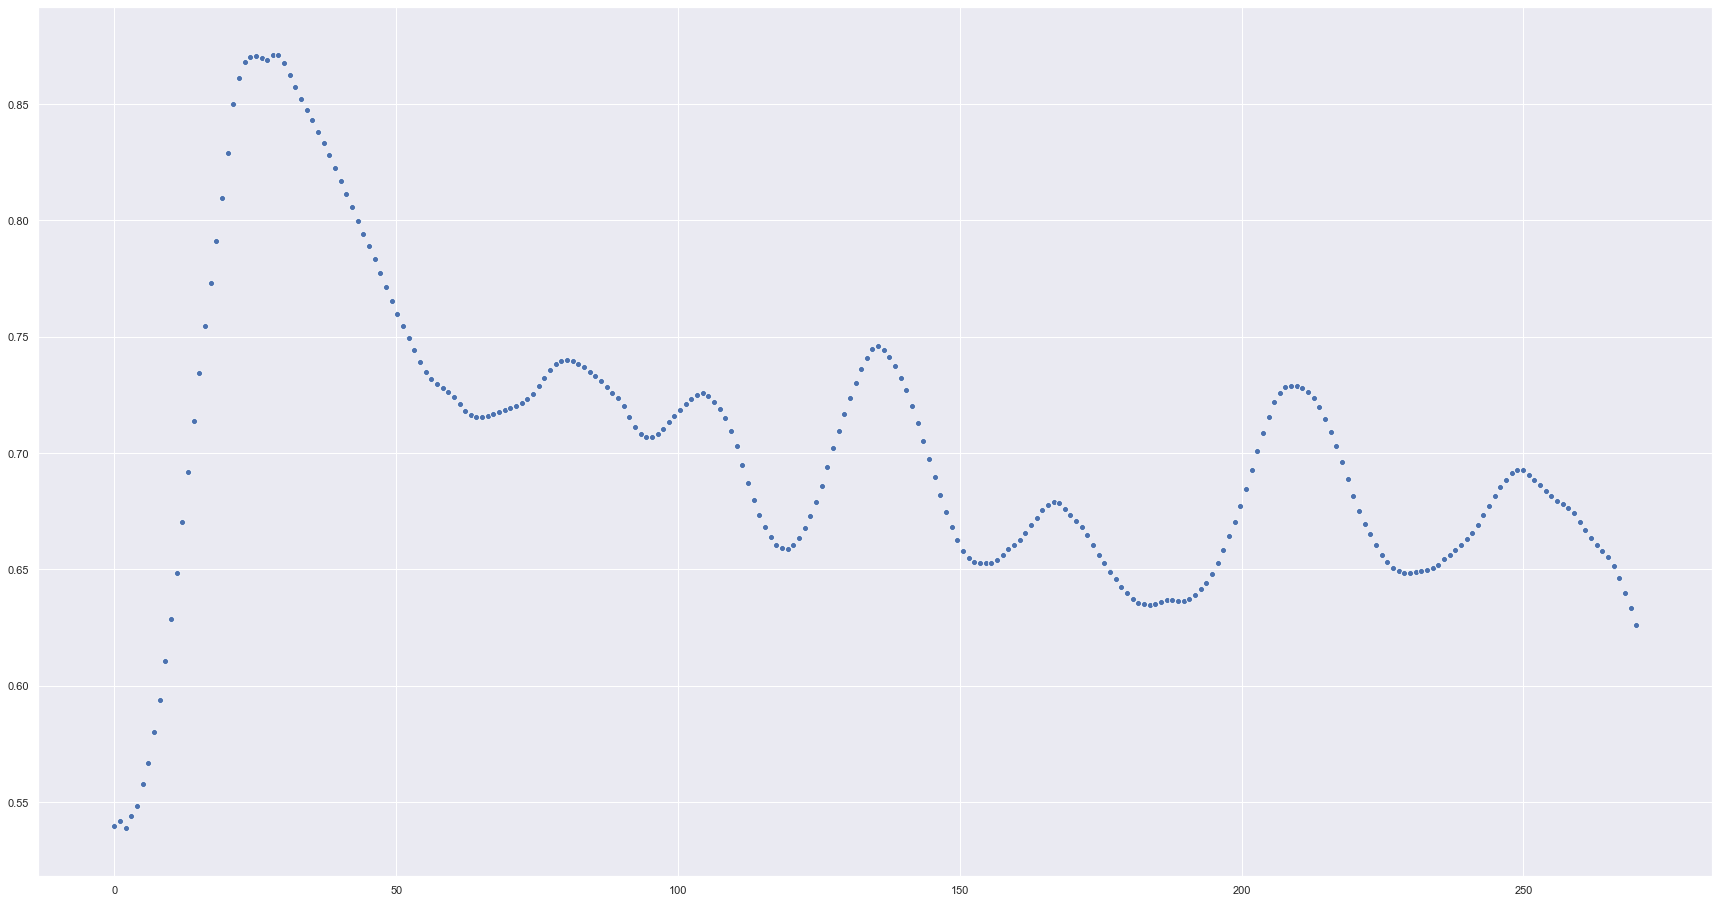

In [180]:
t = np.linspace(0,len(PLV_index),num=len(PLV_index))
sns.scatterplot(t,PLV_index)
chosen_windows =[]
for locmax in local_maxima:
    if PLV_index[locmax]>0.7:
        chosen_windows.append(locmax)
windows_to_remove =[]
for w in chosen_windows:
    for c in chosen_windows:
        if np.abs(w-c)<window_length & w!=c:
            if PLV_index[w]>PLV_index[c]:
                windows_to_remove.append(c)
chosen_windows = sorted(list(set(chosen_windows) - set(windows_to_remove)))
E = len(chosen_windows)

### We want to find an (optimal) window length that makes sure we capture each local max in phase-locking

In [182]:
#THIS CELL TAKES AGES TO RUN

window_length = 100
c = 0
results = np.zeros((20,2))
while window_length>=5:
    PLV_index = np.zeros(300-window_length)
    for t0 in range(0,300-window_length):
        PLV = KFB.CalculatePhaseLockingValue(Hilbert[t0:t0+window_length,:])
        PLV_index[t0] = KFB.CalculatePhaseLockingIndex(PLV)
    local_maxima = argrelextrema(PLV_index,np.greater)[0]
    chosen_windows =[]
    for locmax in local_maxima:
        if PLV_index[locmax]>0.7:
            chosen_windows.append(locmax)
    windows_to_remove =[]
    for w in chosen_windows:
        for c in chosen_windows:
            if np.abs(w-c)<window_length & w!=c:
                if PLV_index[w]>PLV_index[c]:
                    windows_to_remove.append(c)
    chosen_windows = sorted(list(set(chosen_windows) - set(windows_to_remove)))
    E = len(chosen_windows)
    results[c,0] = window_length
    results[c,1] = E
    c+=1
    window_length-=5
results

KeyboardInterrupt: 

### Now that we have extracted the chosen phase locked windows, we extract a functional pattern for each one

In [72]:
BOLDPhases = np.zeros((window_length,N,E))
BOLDPhases_no_mod = np.zeros((window_length,N,E))

for i in range(0,E):
    t0 = chosen_windows[i]
    BOLDPhases[:,:,i] = Hilbert[t0:t0+window_length,:]
    BOLDPhases_no_mod[:,:,i] = KFB.RemoveBounds(BOLDPhases[:,:,i])

#Complete identical steps to in previous cases to extract R and F matrices for these 2 phase locked states



In [112]:
Average_Cos_Phase_Difference = np.zeros((N,N,E))
SyntheticFC = np.zeros((N,N,E))
x_min_brain = np.zeros((N,E))
EstimatedPhases = np.zeros((N,E))
for w in range(0,E):
    Cos_Phase_Differences = np.zeros((N,N,window_length))
    Phase_Differences = np.zeros((N,N,window_length))
    for i in range(0,window_length):
        for j in range(0,N):
            for k in range(0,N):
                Cos_Phase_Differences[j][k][i] = np.cos(BOLDPhases_no_mod[i][k][w]-BOLDPhases_no_mod[i][j][w])
                Phase_Differences[j][k][i] = BOLDPhases_no_mod[i][k][w]-BOLDPhases_no_mod[i][j][w]
    Average_Cos_Phase_Difference[:,:,w] = np.mean(Cos_Phase_Differences,axis=2)
    Average_Phase_Difference = np.mean(Phase_Differences,axis=2)
    C = KFB.CalculateCFromMeanPhaseDiff(Average_Phase_Difference)
    EstimatedPhases[:,w] = GPM.GPMAlgorithm(C)
    x_min_brain[:,w] = KFB.CalculateXMinFromPhases(EstimatedPhases[:,w])
    SyntheticFC[:,:,w] = KFB.CalculateCorrelationMatrixFromPhases(EstimatedPhases[:,w])

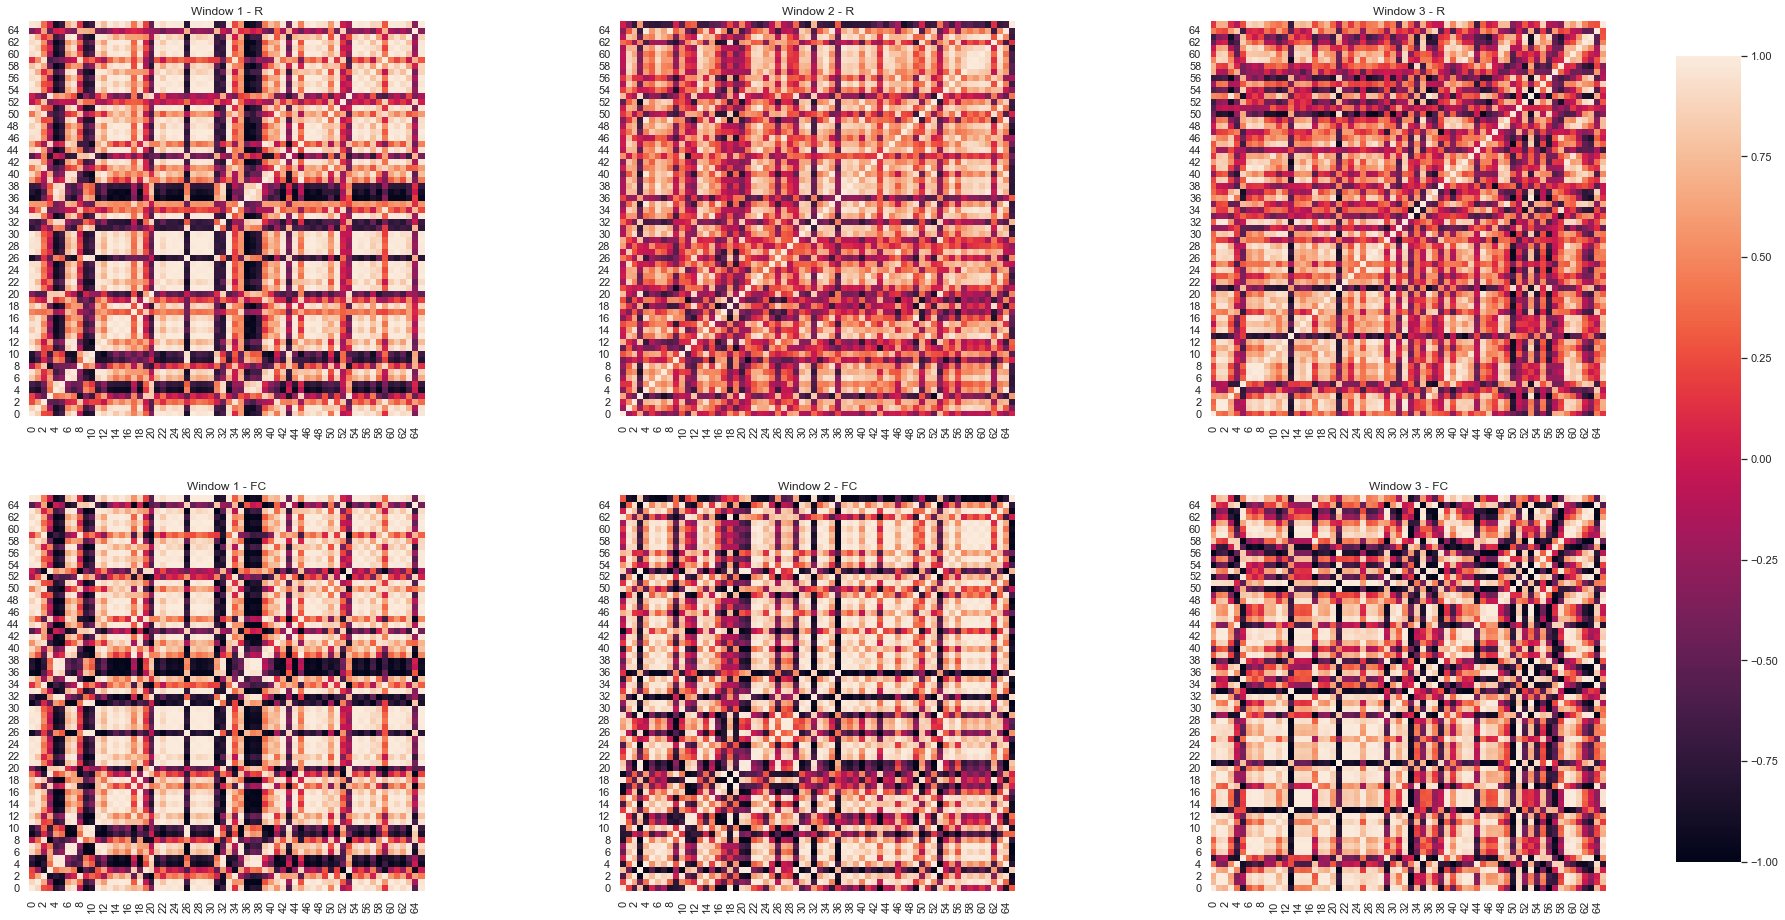

In [80]:
sns.set(rc={'figure.figsize':(30,16)})

fig, axs = plt.subplots(2,3)
cbar_ax = fig.add_axes([.91, .15, .03, .7])
axs[0,0]= sns.heatmap(Average_Cos_Phase_Difference[:,:,0].T,ax=axs[0,0],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0,0].invert_yaxis()
axs[0,1]= sns.heatmap(Average_Cos_Phase_Difference[:,:,1].T,ax=axs[0,1],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0,1].invert_yaxis()
axs[0,2]= sns.heatmap(Average_Cos_Phase_Difference[:,:,2].T,ax=axs[0,2],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0,2].invert_yaxis()
axs[0,0].title.set_text('Window 1 - R')
axs[0,1].title.set_text('Window 2 - R')
axs[0,2].title.set_text('Window 3 - R')
axs[1,0]= sns.heatmap(SyntheticFC[:,:,0].T,ax=axs[1,0],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1,0].invert_yaxis()
axs[1,1]= sns.heatmap(SyntheticFC[:,:,1].T,ax=axs[1,1],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1,1].invert_yaxis()
axs[1,2]= sns.heatmap(SyntheticFC[:,:,2].T,ax=axs[1,2],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1,2].invert_yaxis()
axs[1,0].title.set_text('Window 1 - FC')
axs[1,1].title.set_text('Window 2 - FC')
axs[1,2].title.set_text('Window 3 - FC')
plt.show()

### Now import structural connectivity and find a compatible frequency setting

In [ ]:
SC_DF = pd.read_csv('StructuralConnectivity.csv',header=None)
SCMatrix = np.array(SC_DF)
#Remove Diagonals
SCMatrix = SCMatrix - np.diagflat(np.diag(SCMatrix))
SCMatrix = (SCMatrix+SCMatrix.T)/2

#Calculate quantities from inital parameters 
edges = KFB.CalculateEdgeSet(SCMatrix)
x_desired = np.zeros((len(edges),E))
D = np.zeros((len(edges),len(edges),E))
B = KFB.CalculateIncidenceMatrix(edges,N)
for w in range(0,E):
    x_desired[:,w] = KFB.CalculatePhaseDifferencesFromMin(x_min_brain[:,w],edges)
    D[:,:,w]= KFB.CalculateSinMatrix(edges,x_desired[:,w])
delta1 = KFB.CalculateDeltaFromAdj(SCMatrix,edges)

### There are three approaches to what we could now do:

1. We can aim to find a frequency setting (and maybe have changes to adjacency) that generate all three functional patterns with different initial conditions. This works but solving a convex optimisation problem with an additional constraint for each functional pattern. This would be optimal, but it doesn't seem to have a solution

2. We can aim to find the best fit to all three. This works by loosening the constraint be in the minimisation term. We aim to minimise the difference rather than have an equality constraint. This has a solution but the solution is terrible at reconstructing the functional patterns and therefore not really useful

These observations suggest that these 3 phase-locked patterns have different natural frequencies so cannot be fitted with a single frequency setting. We can calculate a different natural frequency for each functional pattern. 

3. Instead, if these functional patterns are generated by oscillators of different frequencies then we have to have a multi-frequency defnition of brain state.

In [129]:
# Construct the problem and solve the convex optimisation problem
delta_opt = cp.Variable((len(edges),1))
w_opt = cp.Variable((N,1))
objective = cp.Minimize(cp.sum_squares(delta_opt-delta1))
constraints = [delta_opt-delta1>=0]
for w in range(0,E):
    constraints.append(np.matmul(B,D[:,:,w])@delta_opt == w_opt)
prob = cp.Problem(objective, constraints)
result = prob.solve()
#Reobtain adjacency from delta vector and update frequencies
SC_opt = KFB.CalculateAdjFromDelta(delta_opt.value,edges,N)
w_opt = w_opt.value

TypeError: 'NoneType' object is not subscriptable

In [135]:
# Construct the problem and solve the convex optimisation problem to find an optimal frequency setting for all three patterns
delta_opt = cp.Variable((len(edges),1))
w_opt = cp.Variable((N,1))
objective = cp.Minimize(cp.sum_squares(delta_opt-delta1)+ cp.sum_squares(np.matmul(B,D[:,:,0])@delta_opt - w_opt) + cp.sum_squares(np.matmul(B,D[:,:,1])@delta_opt - w_opt)+ cp.sum_squares(np.matmul(B,D[:,:,2])@delta_opt - w_opt))
constraints = [delta_opt-delta1>=0]
prob = cp.Problem(objective, constraints)
result = prob.solve()
#Reobtain adjacency from delta vector and update frequencies
SC_opt = KFB.CalculateAdjFromDelta(delta_opt.value,edges,N)
w_opt = w_opt.value

In [136]:
#Solving the model with these params
T=40
num_points = 800
sol = np.zeros((num_points,N,E))
for w in range(0,E):
    theta_0 = EstimatedPhases[:,w]
    sol[:,:,w],t = KFB.SolveKuramotoModel(theta_0,T,N,w_opt+0.29,SC_opt,num_points)

In [137]:
rho = np.zeros((N,N,E))
for w in range(0,E):
    for i in range(0,N):
        for j in range(i+1,N):
            rho[i,j,w]=np.mean(np.cos(sol[:,j,w]-sol[:,i,w]))
    rho[:,:,w] = rho[:,:,w] + rho[:,:,w].T + np.identity(N)

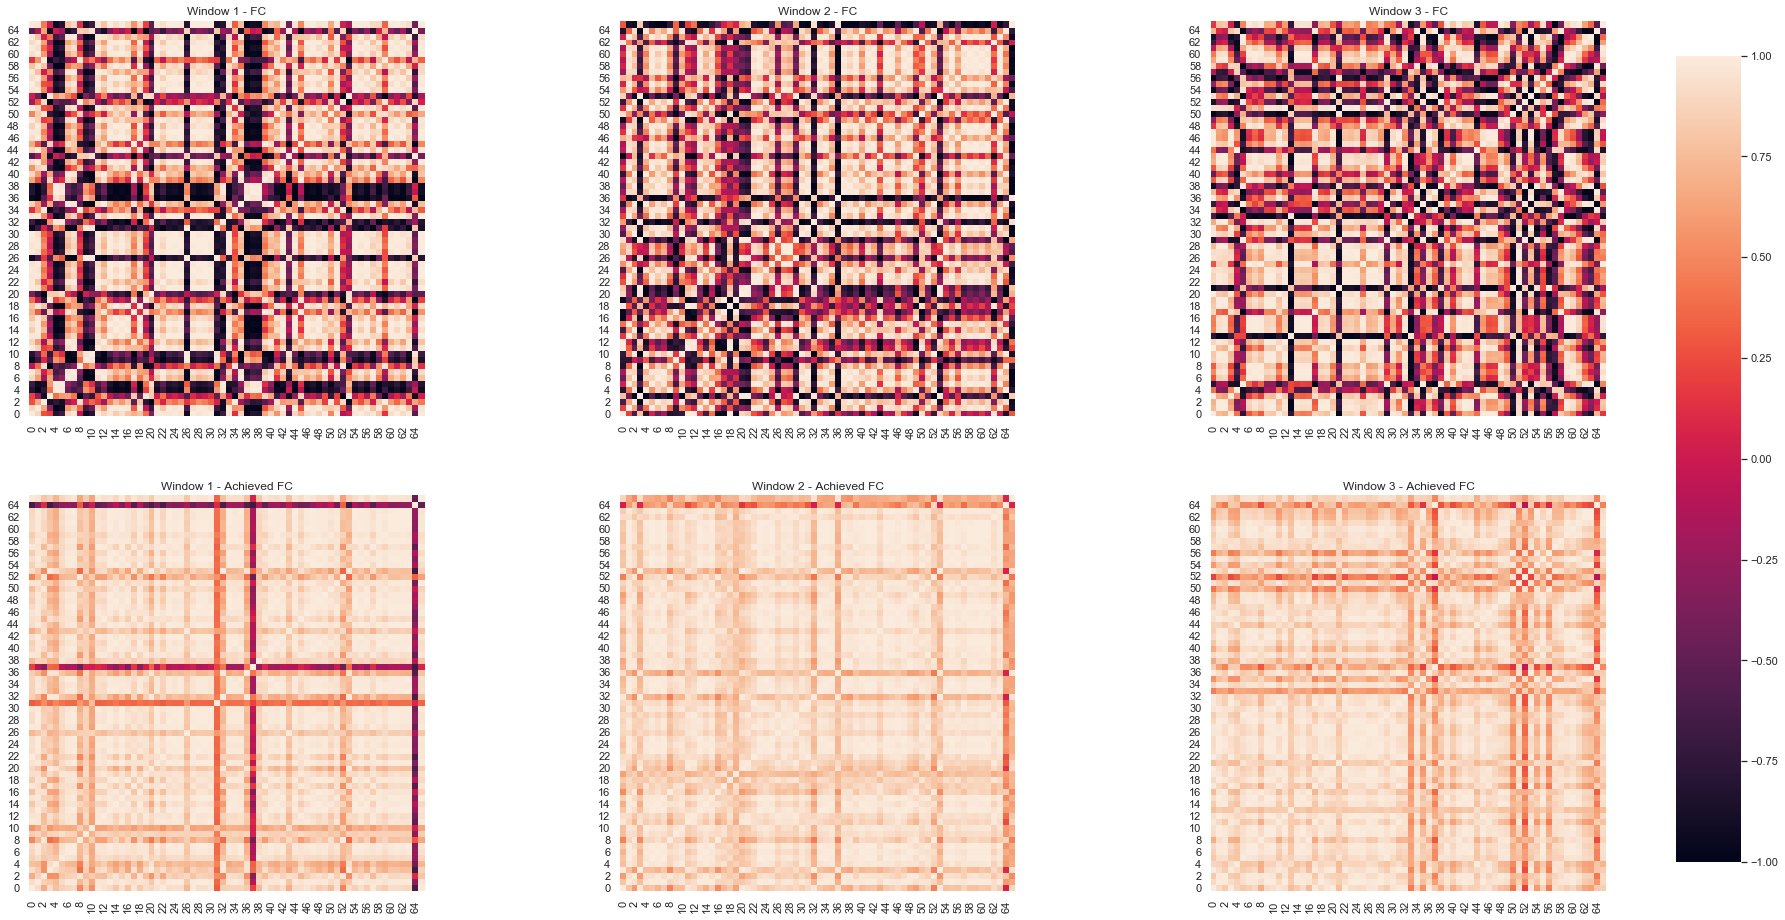

In [138]:
sns.set(rc={'figure.figsize':(30,16)})

fig, axs = plt.subplots(2,3)
cbar_ax = fig.add_axes([.91, .15, .03, .7])
axs[0,0]= sns.heatmap(SyntheticFC[:,:,0].T,ax=axs[0,0],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0,0].invert_yaxis()
axs[0,1]= sns.heatmap(SyntheticFC[:,:,1].T,ax=axs[0,1],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0,1].invert_yaxis()
axs[0,2]= sns.heatmap(SyntheticFC[:,:,2].T,ax=axs[0,2],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0,2].invert_yaxis()
axs[0,0].title.set_text('Window 1 - FC')
axs[0,1].title.set_text('Window 2 - FC')
axs[0,2].title.set_text('Window 3 - FC')
axs[1,0]= sns.heatmap(rho[:,:,0].T,ax=axs[1,0],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1,0].invert_yaxis()
axs[1,1]= sns.heatmap(rho[:,:,1].T,ax=axs[1,1],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1,1].invert_yaxis()
axs[1,2]= sns.heatmap(rho[:,:,2].T,ax=axs[1,2],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1,2].invert_yaxis()
axs[1,0].title.set_text('Window 1 - Achieved FC')
axs[1,1].title.set_text('Window 2 - Achieved FC')
axs[1,2].title.set_text('Window 3 - Achieved FC')
plt.show()

### Here we are trying to obtain three different frequency settings - one for each functional pattern

In [149]:
omega = np.zeros((N,1,E))
for w in range(0,E):
    omega[:,:,w]= np.matmul(B,D[:,:,w])@delta1

In [152]:
#Solving the model with these params
T=40
num_points = 800
sol = np.zeros((num_points,N,E))
for w in range(0,E):
    theta_0 = EstimatedPhases[:,w]
    sol[:,:,w],t = KFB.SolveKuramotoModel(theta_0,T,N,omega[:,:,w]+0.29,SCMatrix,num_points)

In [153]:
rho = np.zeros((N,N,E))
for w in range(0,E):
    for i in range(0,N):
        for j in range(i+1,N):
            rho[i,j,w]=np.mean(np.cos(sol[:,j,w]-sol[:,i,w]))
    rho[:,:,w] = rho[:,:,w] + rho[:,:,w].T + np.identity(N)

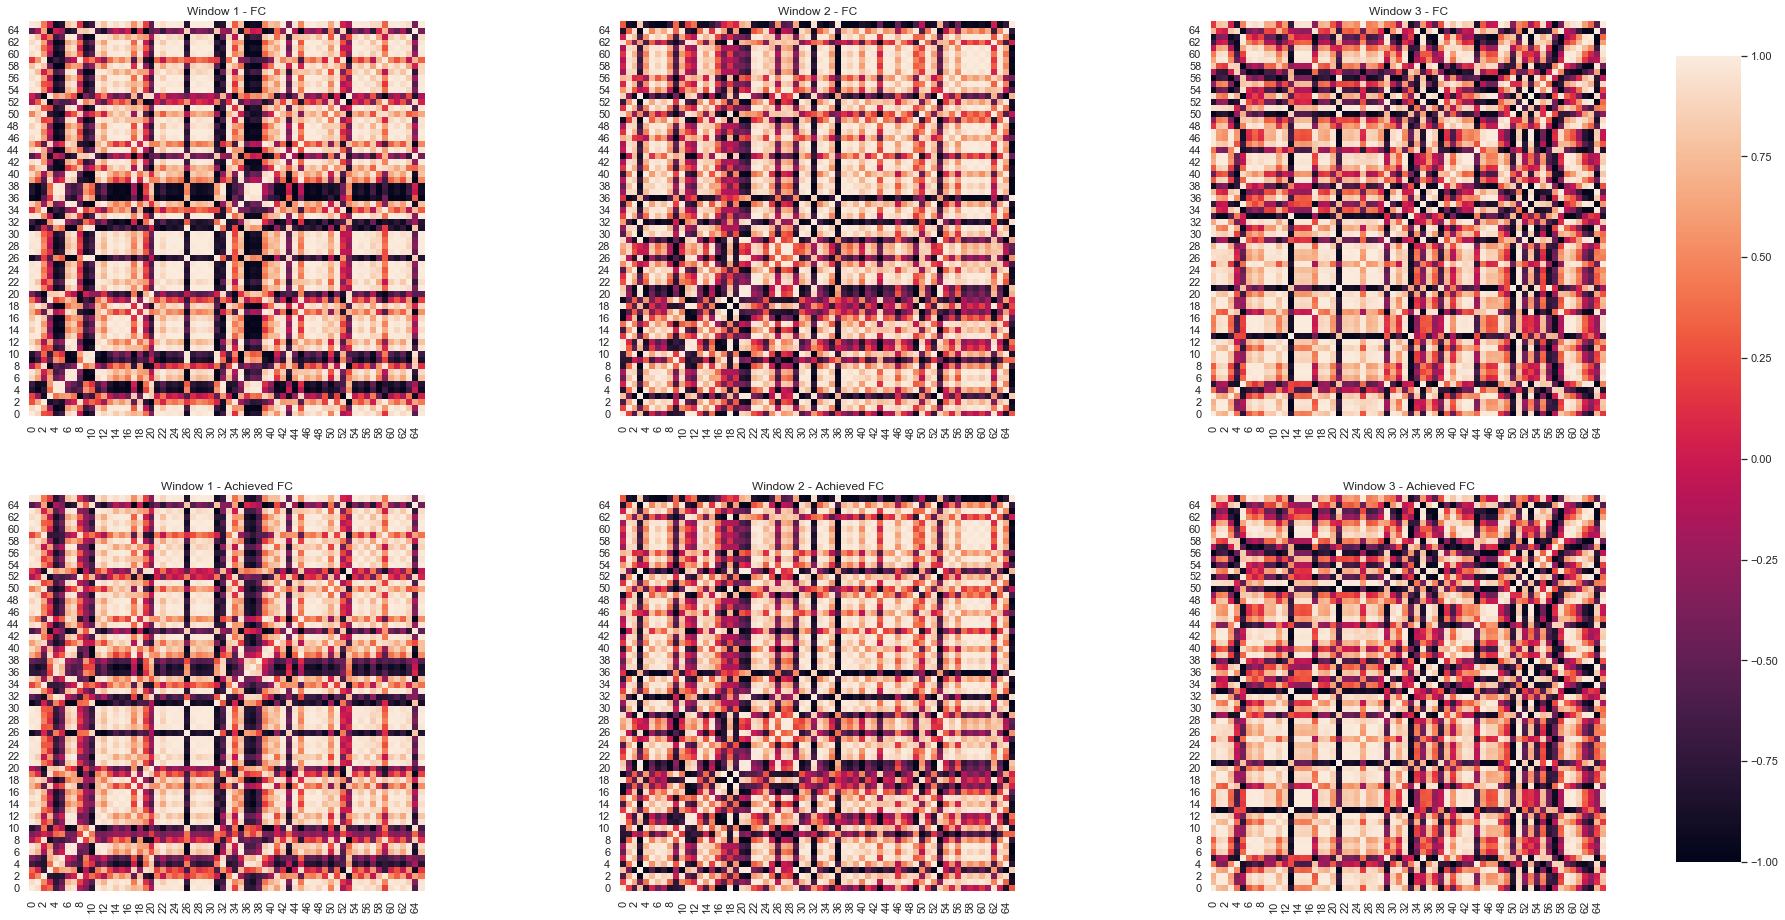

In [154]:
sns.set(rc={'figure.figsize':(30,16)})

fig, axs = plt.subplots(2,3)
cbar_ax = fig.add_axes([.91, .15, .03, .7])
axs[0,0]= sns.heatmap(SyntheticFC[:,:,0].T,ax=axs[0,0],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0,0].invert_yaxis()
axs[0,1]= sns.heatmap(SyntheticFC[:,:,1].T,ax=axs[0,1],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0,1].invert_yaxis()
axs[0,2]= sns.heatmap(SyntheticFC[:,:,2].T,ax=axs[0,2],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0,2].invert_yaxis()
axs[0,0].title.set_text('Window 1 - FC')
axs[0,1].title.set_text('Window 2 - FC')
axs[0,2].title.set_text('Window 3 - FC')
axs[1,0]= sns.heatmap(rho[:,:,0].T,ax=axs[1,0],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1,0].invert_yaxis()
axs[1,1]= sns.heatmap(rho[:,:,1].T,ax=axs[1,1],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1,1].invert_yaxis()
axs[1,2]= sns.heatmap(rho[:,:,2].T,ax=axs[1,2],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1,2].invert_yaxis()
axs[1,0].title.set_text('Window 1 - Achieved FC')
axs[1,1].title.set_text('Window 2 - Achieved FC')
axs[1,2].title.set_text('Window 3 - Achieved FC')
plt.show()

### So we can recreate the 3 FP with 3 frequency settings. Assuming that the brain is switching between these phase-locked functional patterns, can we estimate how much time we spend in each one? Can we get a distribution on this?